In [46]:
# coding: utf-8

import data

# data analysis
from math import sqrt,pi,exp
import numpy as np
import pandas as pd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

<br/>
<br/>

___
### Question 1 - Open the  "titanic_train.csv" and "titanic_test.csv"

In [47]:
titanic_train_df = pd.read_csv("data/titanic_train.csv", sep =',')
titanic_test_df = pd.read_csv("data/titanic_test.csv", sep =',')

titanic_combine_df = [titanic_train_df, titanic_test_df]

titanic_train_df.head().dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
FullName        object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [48]:
titanic_test_df.head().dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
FullName        object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

#### For the explanation of having 2 files 
We have to different files because the purpose of the larger one, the titanic_train.csv is to train our model.  The next one, the titanic_test.csv, is to test the model we'll  have to make in the following question. 

#### Types of the attributes of the dataset
We have 5 integers, 2 floats and 

Five features are strings (object).




## Missing Values 
Cabin > Age > Embarked features contain a number of null values in that order for the training dataset.


In [49]:
total = titanic_train_df.isnull().sum().sort_values(ascending=False)
percent_1 = titanic_train_df.isnull().sum()/titanic_train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
Cabin,450,75.9
Age,120,20.2
Embarked,1,0.2
Fare,0,0.0
Ticket,0,0.0


### Handle missing values in Age feature
We have the Cabin with the highest rate of missing values, we might have to drop  it in order to train our model. For embarked we only  have one missing value, it will  be easy  to fix it. But in the other hand, the attributes Age, we will  have to handle the missing value, 20% of the total of Age values, because it could be important to predict the survival  of the passenger 

In [50]:
data = [titanic_train_df, titanic_test_df]

for dataset in data:
    mean = titanic_train_df["Age"].mean()
    std = titanic_test_df["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = titanic_train_df["Age"].astype(int)
titanic_train_df["Age"].isnull().sum()


0

### Display histogram of people on board

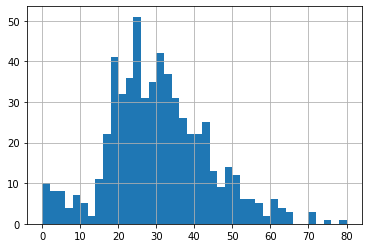

In [51]:
titanic_train_df.Age.hist(bins=  40)

We display  here the histogram  of the age of the passenger of the Titanic from  1 to 80, with the bins of 40 meaning that age will displayed 2 by 2 

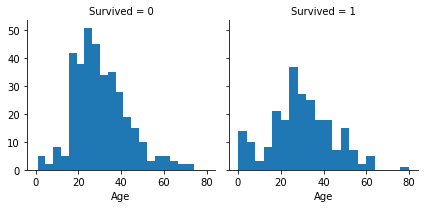

In [52]:
g = sns.FacetGrid(titanic_train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

ANALYSE ???????????

In [53]:
labels = '1', '2', '3'
sizes = titanic_train_df.Pclass.count()
titanic_train_df.groupby(['Pclass']).count()

,PassengerId,Survived,Name,FullName,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Pclass,,,,,,,,,,,,
1,154,154,154,154,154,154,154,154,154,154,127,153
2,124,124,124,124,124,124,124,124,124,124,9,124
3,315,315,315,315,315,315,315,315,315,315,7,315


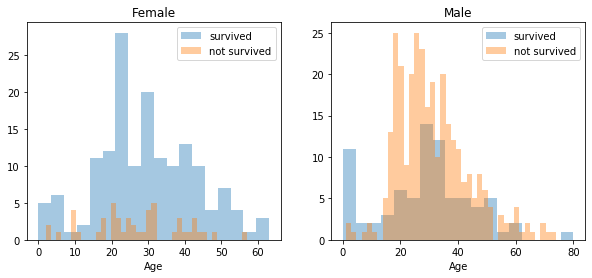

In [54]:
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
women = titanic_train_df[titanic_train_df['Sex']=='female']
men = titanic_train_df[titanic_train_df['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
_ = ax.set_title('Male')

You can see that men have a high probability of survival when they are between 18 and 30 years old, which is also a little bit true for women but not fully. For women the survival chances are higher between 14 and 40.
For men the probability of survival is very low between the age of 5 and 18, but that isn’t true for women. Another thing to note is that infants also have a little bit higher probability of survival.
Since there seem to be certain ages, which have increased odds of survival and because I want every feature to be roughly on the same scale, I will create age groups later on.

In [55]:
data = [titanic_train_df, titanic_test_df]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 18, 'Age'] = 0
    dataset.loc[ dataset['Age'] > 18, 'Age'] = 1

titanic_train_df['Age'].value_counts()

1    492
0    101
Name: Age, dtype: int64

## Question 5 - Influence of the ticket price on survival chances
In both training and test sets, create a "Fare2" attribute whose value is 1 if the ticket price was below 10, 2 below 20, 3 below 30 and 4 otherwise. Using the right tools, determine the strength of the connection between your new "Fare2" attribute and the class the passengers traveled into. Then display the survival rates for each value of "Fare2".
#### Group by fare :

In [72]:
data = [titanic_train_df, titanic_test_df]
for dataset in data:
    dataset['Fare2'] = dataset['Fare'].astype(int)
    dataset.loc[ dataset['Fare2'] <= 10, 'Fare2'] = 1
    dataset.loc[ (dataset['Fare2'] > 10) & (dataset['Fare2'] <= 20), 'Fare2'] = 2
    dataset.loc[ (dataset['Fare2'] > 20) & (dataset['Fare2'] <= 30), 'Fare2'] = 3
    dataset.loc[ dataset['Fare2'] > 30, 'Fare2'] = 4

titanic_train_df.head()

,PassengerId,Survived,Pclass,Name,FullName,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare2
0,299,1,1,Saalfeld,Mr. Adolphe,male,1,0,0,19988,30.5000,C106,S,3
1,300,1,1,Baxter,Mrs. James (Helene DeLaudeniere Chaput),female,1,0,1,PC 17558,247.5208,B58 B60,C,4
2,301,1,3,Kelly,Miss. Anna Katherine Annie Kate,female,1,0,0,9234,7.7500,NaN,Q,1
3,302,1,3,McCoy,Mr. Bernard,male,1,2,0,367226,23.2500,NaN,Q,3
4,303,0,3,Johnson,Mr. William Cahoone Jr,male,1,0,0,LINE,0.0000,NaN,S,1


#### Connection between Fare2 and the class

In [73]:
print(titanic_train_df['Pclass'].unique())
print(titanic_train_df['Fare2'].unique())


[1 3 2]
[3 4 1 2]


#### Display the survival rates for each value of "Fare2"